<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Classical Time Series Forecasting Project Template</h1>
</div>

This notebook shows how to implement time series analysis and forecasting algorithms and serve as a template for time series projects. The implementation of techniques you see in this will come handy as a reproducible reference. 

Though this is termed as a 'template', this is meant only to serve as a starting point for the investigator to build his/her analysis on.

### Content:
1. Load the Data
  - Import libraries
  - Load the datasets
  
2. Overview of the Data
  - Descriptive Statistics
  - Missing Values
  
3. Exploratory Data Analysis and Data Preparation
  - Handle the missing values
  - Visualize the time series using line plot
  - Check distribution of the time series
  - Check monthly seasonality using multiple lines
  - Check monthly seasonality and yearly trend using box plot
  - Decompose the time series
  - Stationarity test - Augmented Dickey Fuller test (ADH Test)
  - ACF-PACF plots and Find the order of differencing 
  
4. Model Building
  - Transform the data using box-cox transformation
  - Split data in train-test dataset
  - Model 1 - ARIMA
  - Model 2 - SARIMA
  - Model 3 - SARIMAX
  - Model 4 - Simple Exponential Smoothing
  - Model 5 - Holt-Winters
  - Define function to evaluate models
  - Train and evaluate the model
  - Save the model

## Inputs

The notebook is designed in such a way that you just need to plug in the input values given below and run the code. It will run on it's own and will build the model as well. 

In [1]:
# Input file name with path
input_file_name = 'time_series_data.csv'

# Target class name
input_target_variable = 'value'

# Date column name
input_date_variable = 'date'

# Exogenous variable
input_exogenous_variable = 'month_no'

# Handle missing value
input_treat_missing_value = 'interp1d' # choose how to handle missing values from 'ffill','bfill' and 'interp1d'

# Box-cox transformation flag
input_transform_flag = 'Yes' # choose if you wish to transform the data - 'Yes' or 'No'

# Seasonality
input_seasonality = 12
input_order = (0, 1 , 2)
input_seasonal_order = (2, 1, 0, input_seasonality)

# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Load the Data</h2>
</div>

In this section you will:

- Import the libraries
- Load the dataset

### 1.1. Import Libraries

Import all the libraries in the first cell itself

In [8]:
! pip install pmdarima

     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 9.5MB 15.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [9]:
# Import libraries 

# Data Manipulation
import numpy as np 
import pandas as pd
from   pandas import DataFrame

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# Set the options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 120})

### 1.2. Load the datasets

Load the dataset using pd.read_csv()

In [10]:
# Read data in form of a csv file
df = pd.read_csv(input_file_name)

df[input_date_variable] = pd.to_datetime(df[input_date_variable])

# First 5 rows of the dataset
df.head()

,date,value,month_no
0,1991-07-01,3.526591,7
1,1991-08-01,3.180891,8
2,1991-09-01,3.252221,9
3,1991-10-01,3.611003,10
4,1991-11-01,3.565869,11


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Overview of the Data</h2>
</div>

Before attempting to solve the problem, it's very important to have a good understanding of data.

In this section you will:
- Get the descriptive statistics of the data
- Get the information about missing values in the data

### 2.1. Descriptive Statistics

As the name says descriptive statistics describes the data. It gives you information about
- Mean, median, mode 
- Min, max
- Count etc

Let's understand the data we have

In [11]:
# Dimension of the data
df.shape

(204, 3)

In [12]:
# Summary of the dataset
df.describe()

,value,month_no
count,202.000000,204.000000
mean,10.734642,6.500000
std,5.972693,3.460545
min,2.814520,1.000000
25%,5.821731,3.750000
50%,9.473601,6.500000
75%,14.402814,9.250000
max,29.665356,12.000000


### 2.2. Missing Values

Get the info about missing values in the dataframe

In [13]:
# Missing values for every column
df.isna().sum()

date        0
value       2
month_no    0
dtype: int64

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Exploratory Data Analaysis</h2>
</div>

Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns in the data. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

In this section you will:
- Handle the missing values
- Visualize the time series using line plot
- Check distribution of the time series
- Check monthly seasonality using multiple lines. Seasonality may be differ for your series.
- Check monthly seasonality and yearly trend using box plot
- Decompose the time series
- Stationarity test - Augmented Dickey Fuller test (ADH Test)
- ACF-PACF plots and Find the order of differencing 

### 3.1. Handle Missing Values

Time Series algorithms doesn't works if the data is missing. So you need to handle the missing values in order to get the predictions

There are various ways to handle missing values for time series data. Some of the ways are:
- Forward Fill
- Backward Fill
- Linear Interpolation

Here you can decide how you want to handle the missing data

In [14]:
# Select how you wish to treat missing values according to the input provided
if input_treat_missing_value == 'ffill':
    
    # forward fill missing values
    df = df.ffill()

elif input_treat_missing_value == 'bfill': 
    
    # backward fill missing values
    df = df.bfill()
    
elif input_treat_missing_value == 'interp1d':
    
    ## Linear Interpolation
    df['rownum'] = np.arange(df.shape[0])
    df_nona = df.dropna(subset = ['value'])
    f = interp1d(df_nona['rownum'], df_nona['value'])
    df[input_target_variable] = f(df['rownum'])
    df = df.drop('rownum', axis = 1)

In [15]:
df.head()

,date,value,month_no
0,1991-07-01,3.526591,7
1,1991-08-01,3.180891,8
2,1991-09-01,3.252221,9
3,1991-10-01,3.611003,10
4,1991-11-01,3.565869,11


### 3.2. Visualize the time series using line plot

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:
- Whether the trend appears to be level around the mean
- Whether there appear to be any obvious outliers

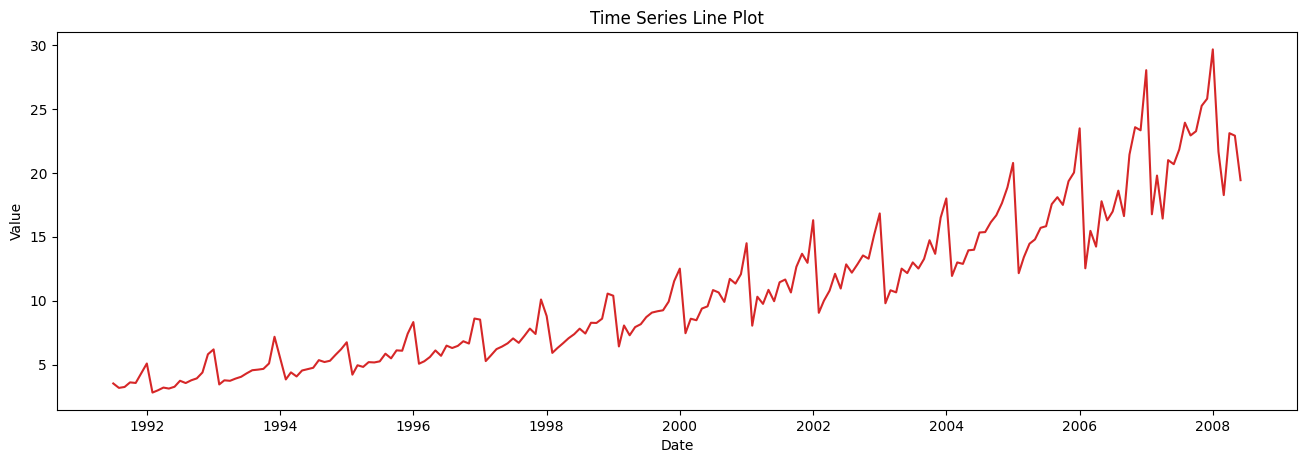

In [16]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df[input_date_variable], y=df[input_target_variable], title='Time Series Line Plot')

If all the values are positive, you can use the below chart to emphasize the growth.

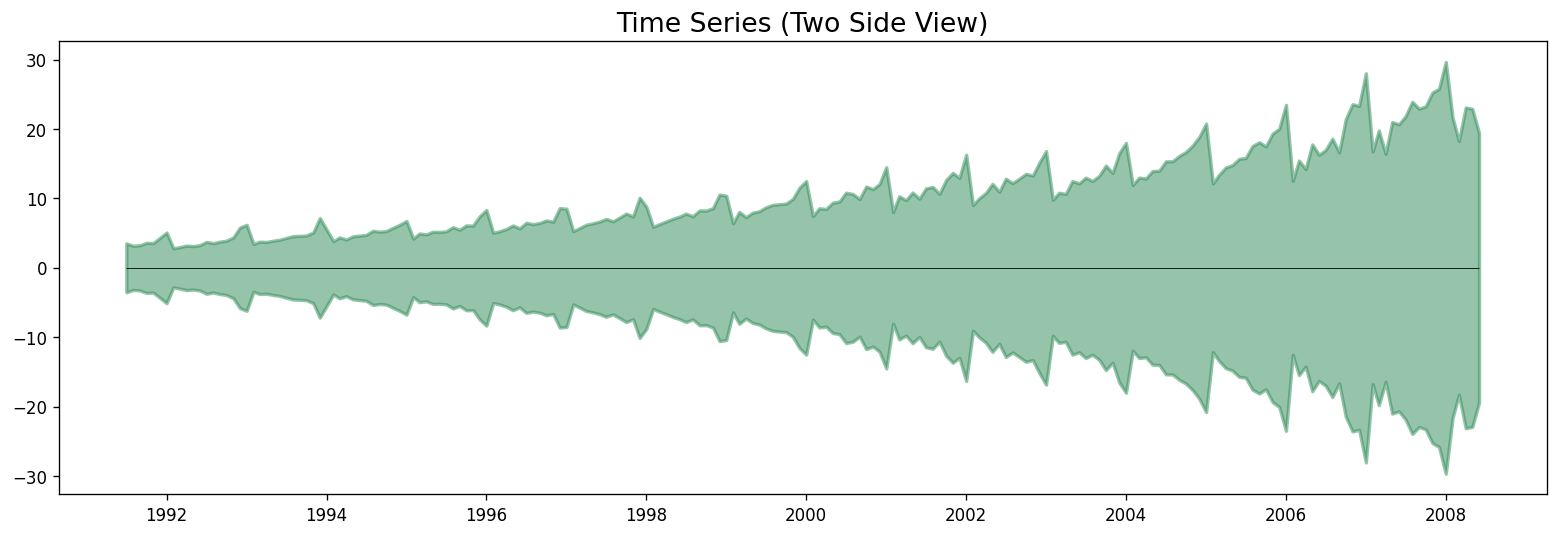

In [17]:
# Draw plot
x = df[input_date_variable]
y1 = df[input_target_variable].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('Time Series (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()

### 3.3. Check distribution of the time series

You should check the distribution of the time series so that you can decide if you need to transform the data or can be used as it is. Additionally, it provides insights about the type of distribution the data follows

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


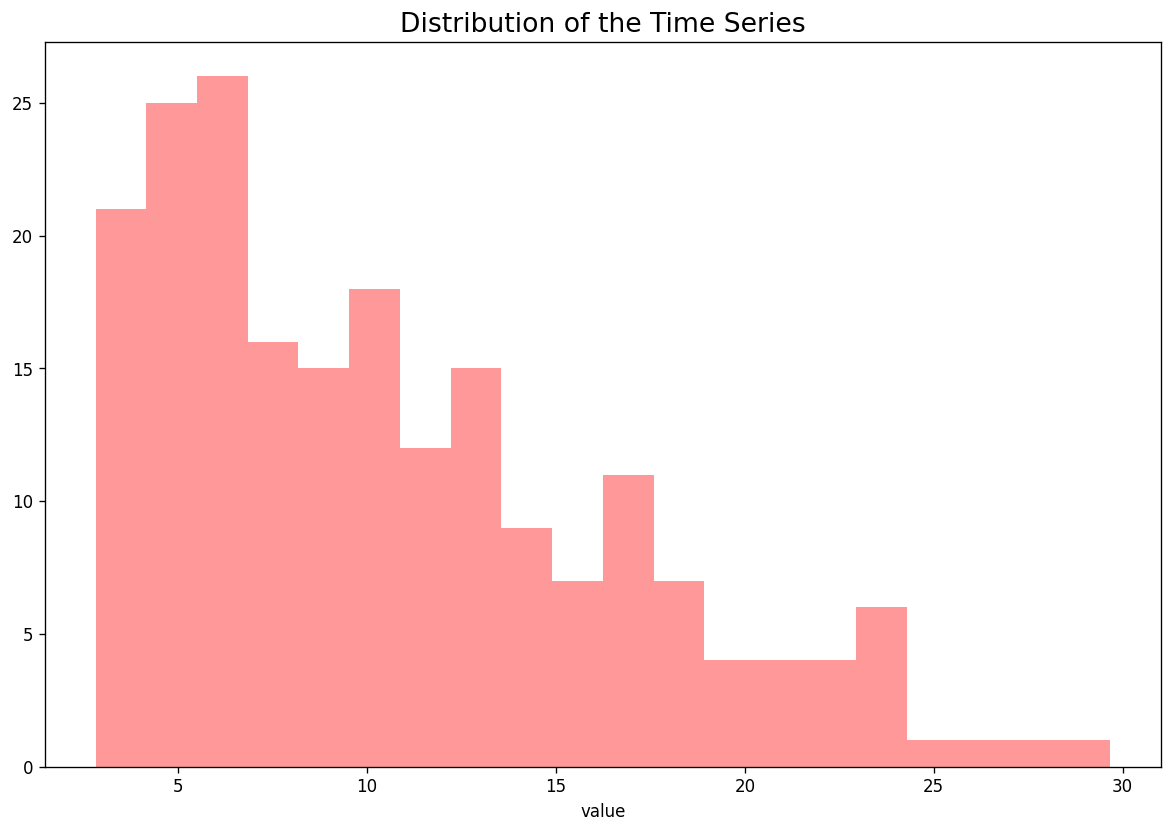

In [18]:
sns.distplot(df[input_target_variable], kde = False, color ='red', bins = 20)
plt.title('Distribution of the Time Series', fontsize=16)
plt.show()

### 3.4. Check monthly seasonality using multiple lines

You can check if the data follows a certain repetitive pattern every year. You can plot each year as a separate line in the same plot. This lets you compare the year wise patterns side-by-side.


This step is applicable for monthly time series. If you have another time series, you can change it to weekly or quaterly or half yearly etc.

In [31]:
def plot_timeseries_divided(df, target_series_name, devided_series_name,  x_series_name, title):

    periods = df[devided_series_name].unique()

    # Prep Colors
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(periods), replace=False)

    # Draw Plot
    plt.figure(figsize=(16,8), dpi= 80)
    for i, y in enumerate(periods):
        if i>0:
            plt.plot(x_series_name, target_series_name, data=df.loc[df[devided_series_name]==y, :], color=mycolors[i], label=y)
            plt.text(df.loc[df[devided_series_name]==y, :].shape[0]-.9, df.loc[df[devided_series_name]==y, target_series_name][-1:].values[0], y, fontsize=12, color=mycolors[i])

    # Decoration
    plt.gca().set(ylabel=target_series_name, xlabel=x_series_name)
    num_ticks=len(df[x_series_name].unique())
    plt.yticks(fontsize=10, alpha=.7)
    plt.title(title, fontsize=20)
    plt.show()

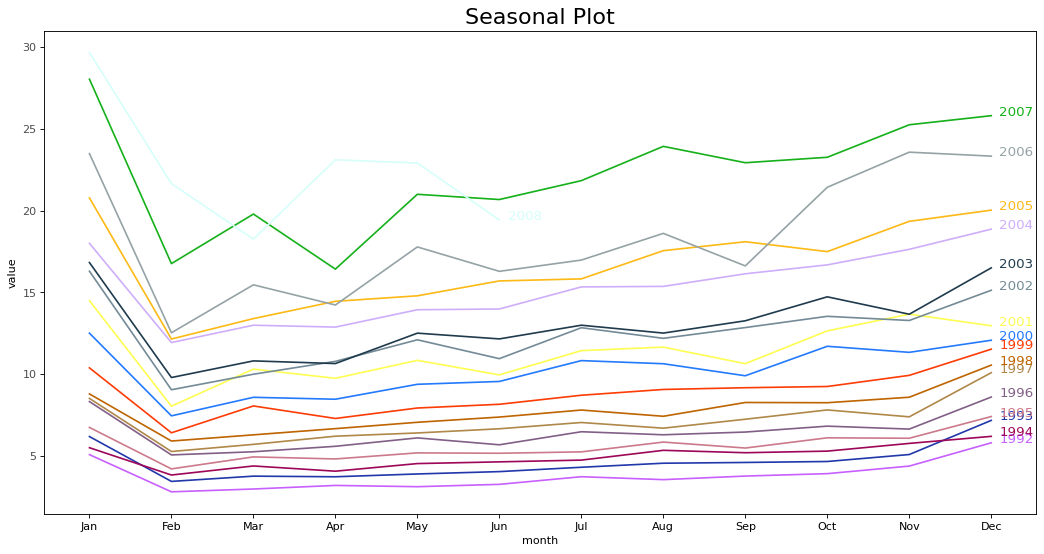

In [32]:
df['year'] = [d.year for d in df[input_date_variable]]
df['month'] = [d.strftime('%b') for d in df[input_date_variable]]
plot_timeseries_divided(df, input_target_variable, 'year', 'month', 'Seasonal Plot')

### 3.5. Plot moving average with confidence intervals

In [34]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


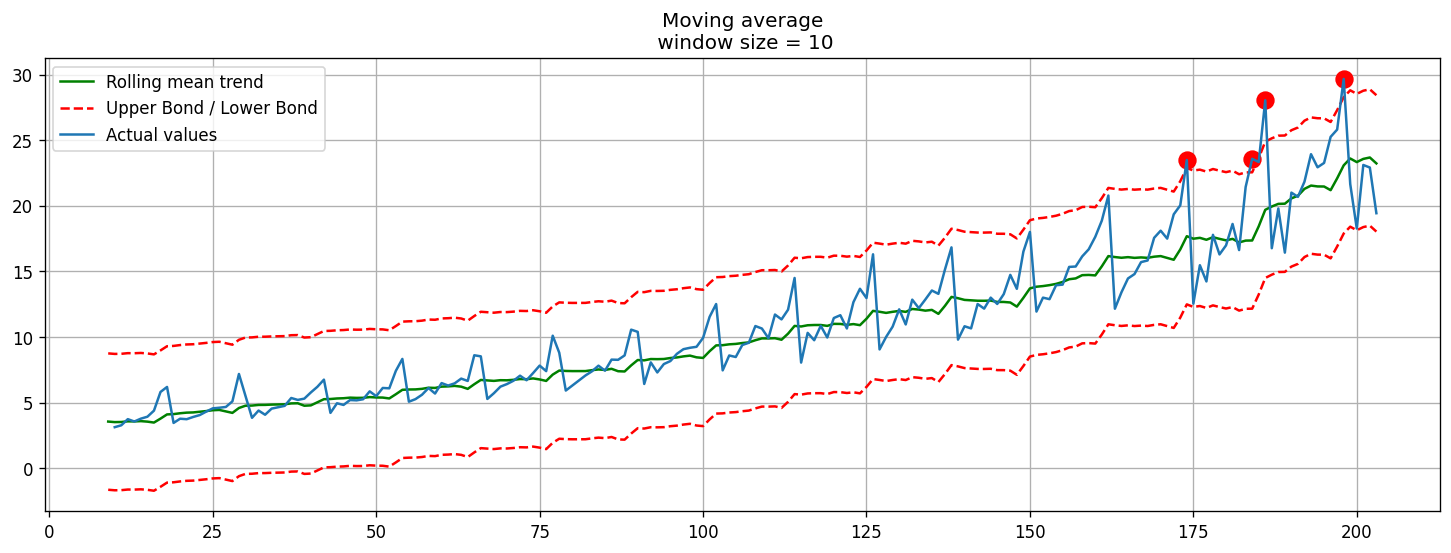

In [40]:
plotMovingAverage(df[['value']], 10, plot_intervals=True, plot_anomalies=True)

### 3.6. Seasonality and Yearly Trend using Box Plot

You can check the yearly trend and monthly seasonality using a box plot.

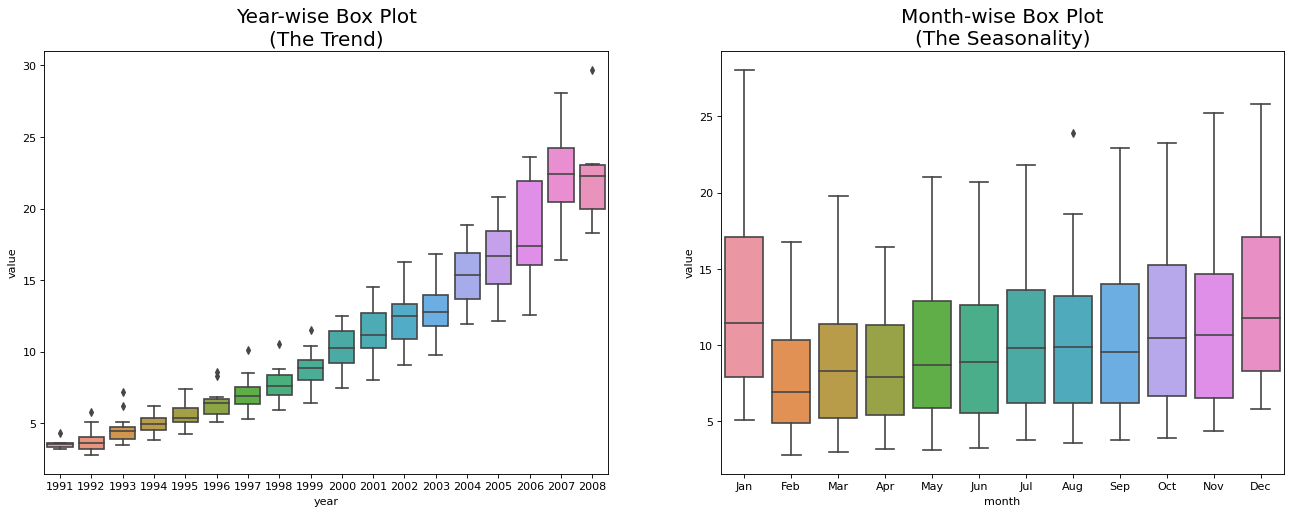

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=input_target_variable, data=df, ax=axes[0])
sns.boxplot(x='month', y=input_target_variable, data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### 3.7. Time Series Decomposition

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

Additive time series:
- Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
- Value = Base Level x Trend x Seasonality x Error

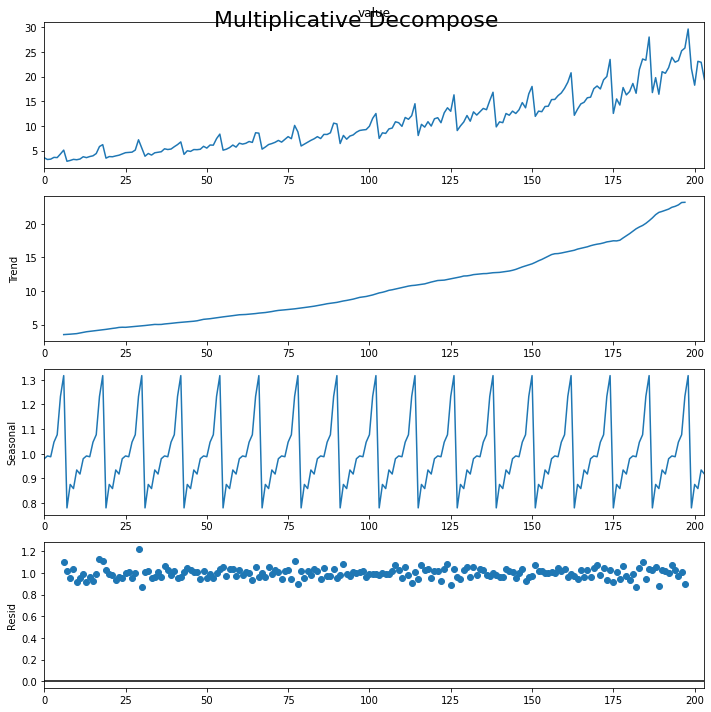

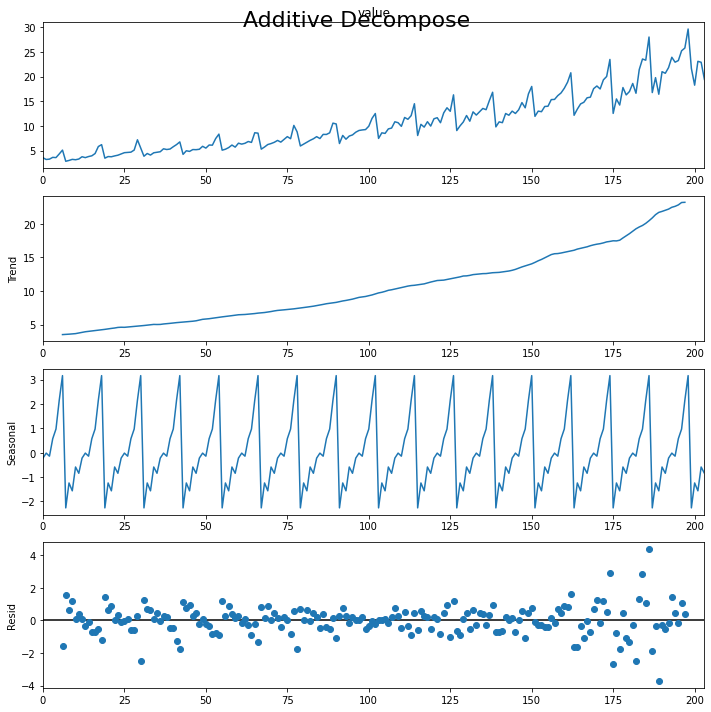

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df[input_target_variable], model='multiplicative', period=input_seasonality)

# Additive Decomposition
result_add = seasonal_decompose(df[input_target_variable], model='additive', period=input_seasonality)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
# Extract the Components ----
# Actual Values = Summation of (Seasonal + Trend + Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head(10)

,seas,trend,resid,actual_values
0,-0.220214,NaN,NaN,3.526591
1,-0.015521,NaN,NaN,3.180891
2,-0.141426,NaN,NaN,3.252221
3,0.576757,NaN,NaN,3.611003
4,0.974431,NaN,NaN,3.565869
5,2.157772,NaN,NaN,4.306371
6,3.166417,3.503344,-1.581426,5.088335
7,-2.264404,3.527891,1.551033,2.814520
8,-1.241074,3.565511,0.661374,2.985811
9,-1.563869,3.600447,1.168202,3.204780


In [ ]:
df.trend = df_reconstructed.trend

/Users/ajaykumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


### 3.8. Stationarity test - Augmented Dickey Fuller test (ADH Test)

There are mulitple tests to test if a time series is stationary or not.

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [ ]:
# ADF Test
result = adfuller(df[input_target_variable].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.1500867620691473
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


### 3.9. ACF-PACF plots and Find the order of differencing 

**How to find the order of differencing?**

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

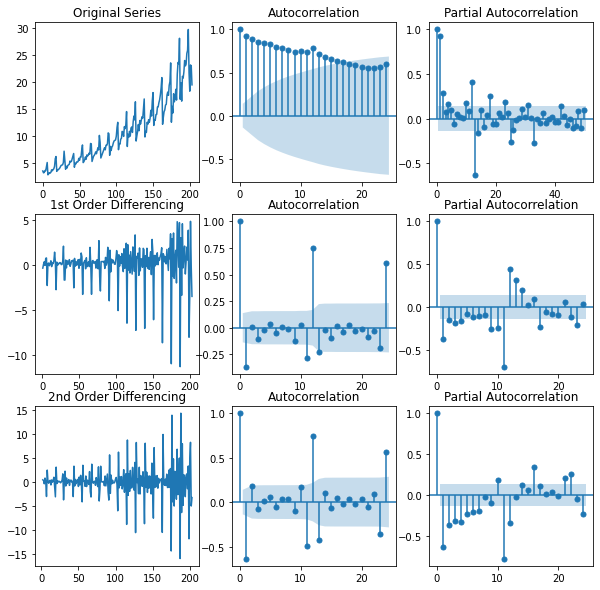

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(df[input_target_variable]); axes[0, 0].set_title('Original Series')
plot_acf(df[input_target_variable], ax=axes[0, 1])
plot_pacf(df[input_target_variable], lags=50, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(df[input_target_variable].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df[input_target_variable].diff().dropna(), ax=axes[1, 1])
plot_pacf(df[input_target_variable].diff().dropna(), ax=axes[1, 2])


# 2nd Differencing
axes[2, 0].plot(df[input_target_variable].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df[input_target_variable].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(df[input_target_variable].diff().diff().dropna(), ax=axes[2, 2])

plt.show()

In [ ]:
# ADF Test for 2 order of differencing
result = adfuller(df[input_target_variable].diff().diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.24021564858297
p-value: 4.771189380515464e-18
Critial Values:
   1%, -3.465811691080702
Critial Values:
   5%, -2.877123351472649
Critial Values:
   10%, -2.5750770662586864


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Model Building</h2>
</div>

In this section you will:
- Transform the data using box-cox transformation
- Split data in train-test dataset
- Model 1 - ARIMA
- Model 2 - SARIMA
- Model 3 - SARIMAX
- Model 4 - Simple Exponential Smoothing
- Model 5 - Holt-Winters
- Define function to evaluate models
- Train and evaluate the model
- Save the model

### 4.1. Box-Cox Tranformation

Transform the data to be normally distributed

In [ ]:
df.head()

,date,value,month_no,year,month
0,1991-07-01,3.526591,7,1991,Jul
1,1991-08-01,3.180891,8,1991,Aug
2,1991-09-01,3.252221,9,1991,Sep
3,1991-10-01,3.611003,10,1991,Oct
4,1991-11-01,3.565869,11,1991,Nov


In [ ]:
# Box - Cox Transform
if input_transform_flag == 'Yes':
    df[input_target_variable], lam = boxcox(df[input_target_variable])
else:
    print("No transformation")

In [ ]:
df.head()

,date,value,month_no,year,month
0,1991-07-01,1.308054,7,1991,Jul
1,1991-08-01,1.197308,8,1991,Aug
2,1991-09-01,1.221057,9,1991,Sep
3,1991-10-01,1.333539,10,1991,Oct
4,1991-11-01,1.319983,11,1991,Nov


### 4.2. Train - Test Window Split

Split the dataset in training and test set

In [ ]:
train_pct = 0.80
train_size = int(len(df) * train_pct)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:]

### 4.3. Model 1 - ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

The initial order of the ARIMA model can be determined using the the ACF and PACF plots. The initial starting point for 'p' is the number of significant lags from the PACF plot and 'q' comes from the number of significant lags from the ACF plot.

You might want to check the error for serial correlation using the Durbin-Watson statistic and ch

I will demonstrate the code in upcoming section.

### 4.4. Model 2 - SARIMA

If a time series has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

I will demonstrate the code in next section

### 4.5. Model 3 - SARIMAX

If a time series has seasonal patterns and an external predictor (also called as exogenous variable), then you need to add seasonal and exogenous terms and it becomes SARIMAX

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

Since ARIMA, SARIMA and SARIMAX are from the same family. I have defined a single function to fit these models automatically.

In [ ]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(train[input_target_variable], exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = True, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

You can fit in the parameters manually as well. 

In [ ]:
def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

### 4.6. Model 4 - Simple Exponential Smoothing

Single Exponential Smoothing is a time series forecasting algorithm for univariate data which doesn't have a trend or seasonality. Only one parameter is required for SES - alpha (a).  It is the smoothing coefficient.

In [ ]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.7. Model 5 - Holt-Winters

Holt-Winters is a time series forecasting algorithm. It models three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

You need to pass on the parameter seasonality to it

In [ ]:
def model_holt_winters(y, seasonality):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend='add', seasonal='add',).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.8. Define function to get the predictions

In [ ]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

### 4.9. Define function to evaluate models

- Durbin Watson Statistic
- MAPE
- MAE
- RSME
- R2 Score

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def durbin_watson_stat(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    return(durbin_watson(validation_df.error))

In [ ]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [ ]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))
    print("Durbin Watson Score : ", durbin_watson_stat(actuals, predictions))
    
    analyse_error(actuals, predictions)
    
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

### 4.10. Train and evaluate the model

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-62.921, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-64.277, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-277.543, Time=0.13 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-291.270, Time=0.29 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-170.108, Time=0.08 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=-228.456, Time=0.35 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-292.750, Time=0.74 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1

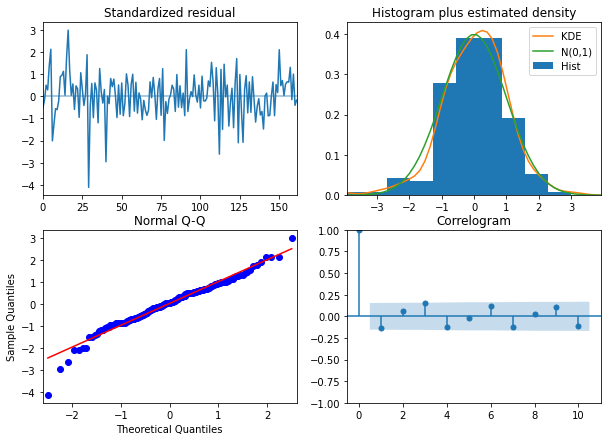

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  2.444536082749596
MAE  :  0.07715418996736337
RMSE  :  0.09606478302071086
R2 Score  :  0.8568868299376438
Durbin Watson Score :  1.9000089131859037


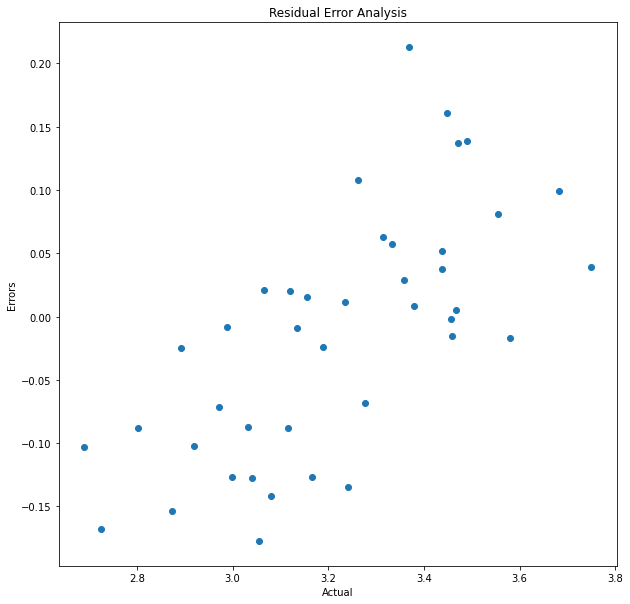

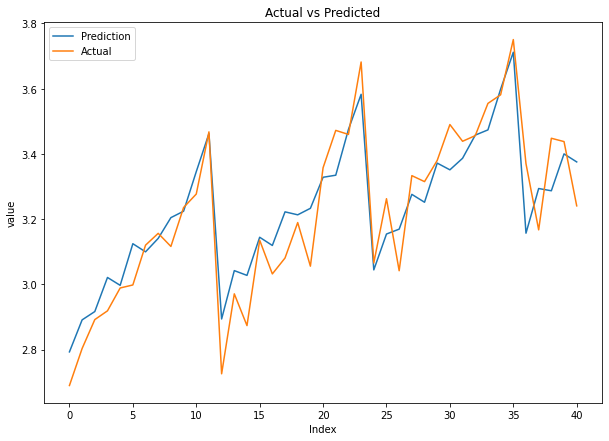

In [ ]:
# Get actual values
actuals = test[input_target_variable].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)

elif input_ts_algo == 'manual_sarima':
    
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = train[input_target_variable], order = input_order, seasonal_order = input_seasonal_order)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target_variable])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target_variable], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)

If you had transformed the y variable, you need to inverse transform it back and then get the evaluation metric

-------------------------- Inverse transform the actual and predicted values and evaluate the model
------------- Model Evaluations --------------- 

MAPE :  6.581694940578228
MAE  :  1.2282222020940794
RMSE  :  1.5318664635853172
R2 Score  :  0.8626037720275499
Durbin Watson Score :  1.9799354142900047


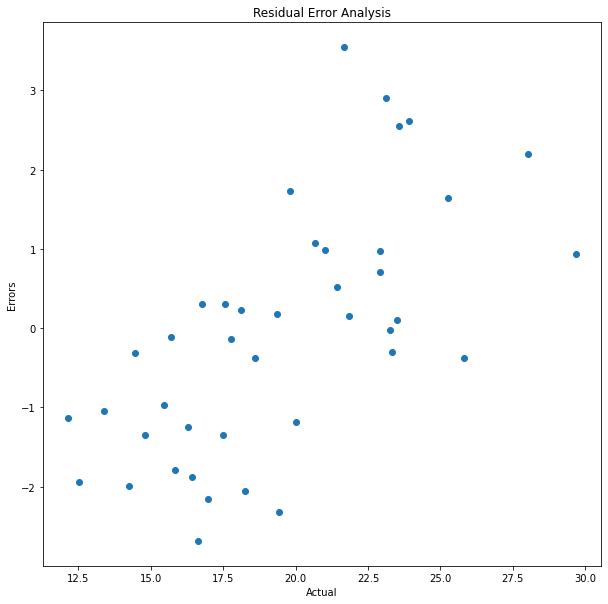

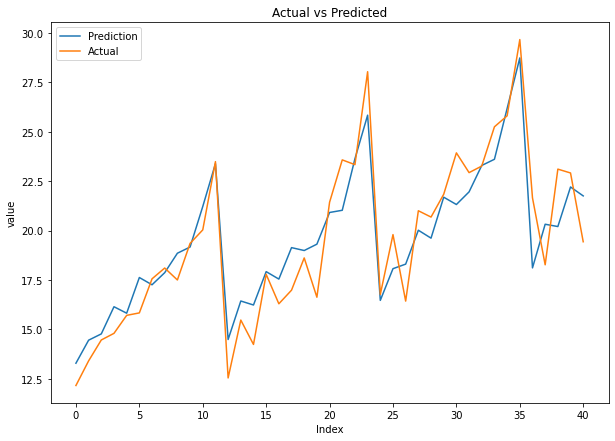

In [ ]:
if input_transform_flag == 'Yes':
    print("-------------------------- Inverse transform the actual and predicted values and evaluate the model")
    actuals = inv_boxcox(actuals, lam)
    predictions = inv_boxcox(predictions, lam)
    evaluate_model(actuals, predictions)
else:
    print("No transformation")

### 4.11. Save the final model

You can save the model in local disk and use it whenever you want

In [ ]:
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)